# Telecom

## Import Packages

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
import statsmodels.formula.api as smf
from sklearn.calibration import calibration_curve

from patsy import dmatrices, dmatrix, build_design_matrices

import math

In [3]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load and Inspect the Data

In [4]:
telecom_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

What are the columns of the dataset?

In [5]:
telecom_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

How many rows and columns do we have?

In [6]:
telecom_df.shape

(7043, 21)

In [7]:
telecom_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

What are the names of the variables in the data frame? How many values are missing? Use our self defined `summarize_dataframe` function to find out the number of NA's for each variable.

In [9]:
summarize_dataframe(telecom_df)

/tmp/ipykernel_86/2366052593.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,object,0,7043,7043.0,7043,3186-AJIEK,1,,,,,,,
gender,object,0,2,7043.0,2,Male,3555,,,,,,,
SeniorCitizen,int64,0,2,7043.0,,,,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,object,0,2,7043.0,2,No,3641,,,,,,,
Dependents,object,0,2,7043.0,2,No,4933,,,,,,,
tenure,int64,0,73,7043.0,,,,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,object,0,2,7043.0,2,Yes,6361,,,,,,,
MultipleLines,object,0,3,7043.0,3,No,3390,,,,,,,
InternetService,object,0,3,7043.0,3,Fiber optic,3096,,,,,,,
OnlineSecurity,object,0,3,7043.0,3,No,3498,,,,,,,


## Engineer Features

In [10]:
telecom_df["Churn_Num"] = np.where(telecom_df['Churn']=='Yes', 1, 0)

## Creating Training and Testing Sets

Once we have this, we can take all of the data before February 19, 2008 as our training set, and all of the data after that point as our testing set.

In [11]:
telecom_df_train, telecom_df_test = train_test_split(telecom_df, test_size=0.2)

## Preprocess Training and Testing Data

In [12]:
list(telecom_df_train.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'Churn_Num']

From the list above, choose some independent variables to put into your models.

In [58]:
ind_var_selected = ['tenure','MultipleLines','Dependents','SeniorCitizen']
df_var_selected = ['Churn_Num','tenure','MultipleLines','Dependents','SeniorCitizen']

In [59]:
X_train = telecom_df_train[ind_var_selected]
y_train = telecom_df_train['Churn_Num']
df_train = telecom_df_train[df_var_selected]

In [60]:
X_test = telecom_df_test[ind_var_selected]
y_test = telecom_df_test['Churn_Num']
df_test = telecom_df_test[df_var_selected]

## Scoring Rules and Benchmarks

In [16]:
bench_5050 = np.repeat(0.5, len(telecom_df_test))

In [17]:
log_loss(y_test, bench_5050)

0.6931471805599454

## Fit a Logistic Regression

In [18]:
lr = smf.logit(formula='Q("Churn_Num") ~ Q("tenure") + Q("MultipleLines") + Q("Dependents") + Q("SeniorCitizen")', data=telecom_df_train).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.475495
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Q("Churn_Num")   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5628
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.1771
Time:                        00:31:54   Log-Likelihood:                -2678.9
converged:                       True   LL-Null:                       -3255.7
Covariance Type:            nonrobust   LLR p-value:                3.608e-247
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.2043      0.058     -3.528      0.000      -0.318      -0.091
Q("MultipleLines")[T.No phone service]     0.3235      0.119      2.711      0.007       0.090       0.557
Q("MultipleLines")[T.Yes]                  0.9661      0.079     12.246      0.000       0.811       1.121
Q("Dependents")[T.Yes]                    -0.5652      0.084     -6.755      0.000      -0.729      -0.401
Q("tenure")                               -0.0475      0.002    -26.031      0.000      -0.051      -0.044
Q("SeniorCitizen")                         0.8310      0.087      9.498      0.000       0.660       1.002
==========================================================================================================
"""

In [19]:
lr_pred = lr.predict(telecom_df_test)

In [20]:
log_loss(y_test, lr_pred)

0.4981851832876789

In [21]:
lr.params

Intercept                                -0.204278
Q("MultipleLines")[T.No phone service]    0.323490
Q("MultipleLines")[T.Yes]                 0.966077
Q("Dependents")[T.Yes]                   -0.565247
Q("tenure")                              -0.047486
Q("SeniorCitizen")                        0.831010
dtype: float64

## Neural Network

In [45]:
formula_binary = 'Churn_Num ~ ' + 'Q("' + '") + Q("'.join(df_train.columns[1:]) + '")'

In [46]:
formula_binary

'Churn_Num ~ Q("tenure") + Q("MultipleLines") + Q("Dependents") + Q("SeniorCitizen")'

In [48]:
y_train_linear_binary, X_train_linear_binary = dmatrices(formula_binary, df_train, return_type="dataframe")

In [49]:
y_train_linear_binary

,Churn_Num
6638,0.0
6011,0.0
4989,0.0
5080,0.0
2258,0.0
...,...
1040,1.0
4535,1.0
4426,0.0
5607,1.0


In [51]:
X_train_linear_binary

,Intercept,"Q(""MultipleLines"")[T.No phone service]","Q(""MultipleLines"")[T.Yes]","Q(""Dependents"")[T.Yes]","Q(""tenure"")","Q(""SeniorCitizen"")"
6638,1.0,0.0,0.0,0.0,57.0,0.0
6011,1.0,0.0,0.0,1.0,37.0,0.0
4989,1.0,1.0,0.0,1.0,7.0,0.0
5080,1.0,0.0,1.0,0.0,67.0,0.0
2258,1.0,0.0,0.0,0.0,56.0,0.0
...,...,...,...,...,...,...
1040,1.0,0.0,0.0,0.0,14.0,1.0
4535,1.0,0.0,1.0,1.0,30.0,0.0
4426,1.0,0.0,1.0,1.0,16.0,0.0
5607,1.0,1.0,0.0,0.0,40.0,1.0


In [62]:
X_test_linear_binary = build_design_matrices([X_train_linear_binary.design_info], df_test, return_type="dataframe")[0]
X_test_linear_binary.shape

(1409, 6)

In [55]:
%%time
nn_model_binary = MLPClassifier(activation='relu', 
                                hidden_layer_sizes=(4,3), 
                                alpha = .0001,
                                random_state=23)
nn_model_binary.fit(X_train_linear_binary, y_train_linear_binary.values.ravel())

CPU times: user 559 ms, sys: 1.79 ms, total: 560 ms
Wall time: 559 ms


MLPClassifier(hidden_layer_sizes=(4, 3), random_state=23)

In [63]:
nn_pred_binary = nn_model_binary.predict_proba(X_test_linear_binary)[:,1]

In [72]:
roc_auc_score(df_test['Churn_Num'], nn_pred_binary)

0.7597429423326609

In [75]:
# Compute calibration curve for the training set
train_fraction_of_positives, train_mean_predicted_value = calibration_curve(df_train['Churn_Num'], nn_model_binary.predict_proba(X_train_linear_binary)[:,1], n_bins=10)

# Compute calibration curve for the test set
test_fraction_of_positives, test_mean_predicted_value = calibration_curve(df_test['Churn_Num'], nn_pred_binary , n_bins=10)

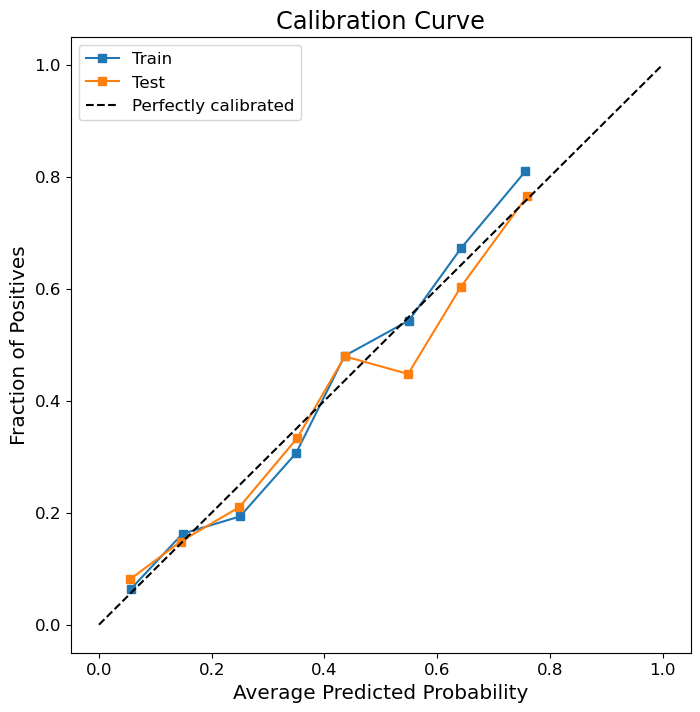

In [76]:
# Plot calibration curves
plt.figure(figsize=(8, 8))
plt.plot(train_mean_predicted_value, train_fraction_of_positives, "s-", label="Train")
plt.plot(test_mean_predicted_value, test_fraction_of_positives, "s-", label="Test")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.ylabel("Fraction of Positives")
plt.xlabel("Average Predicted Probability")
plt.legend()
plt.title("Calibration Curve")
plt.show()

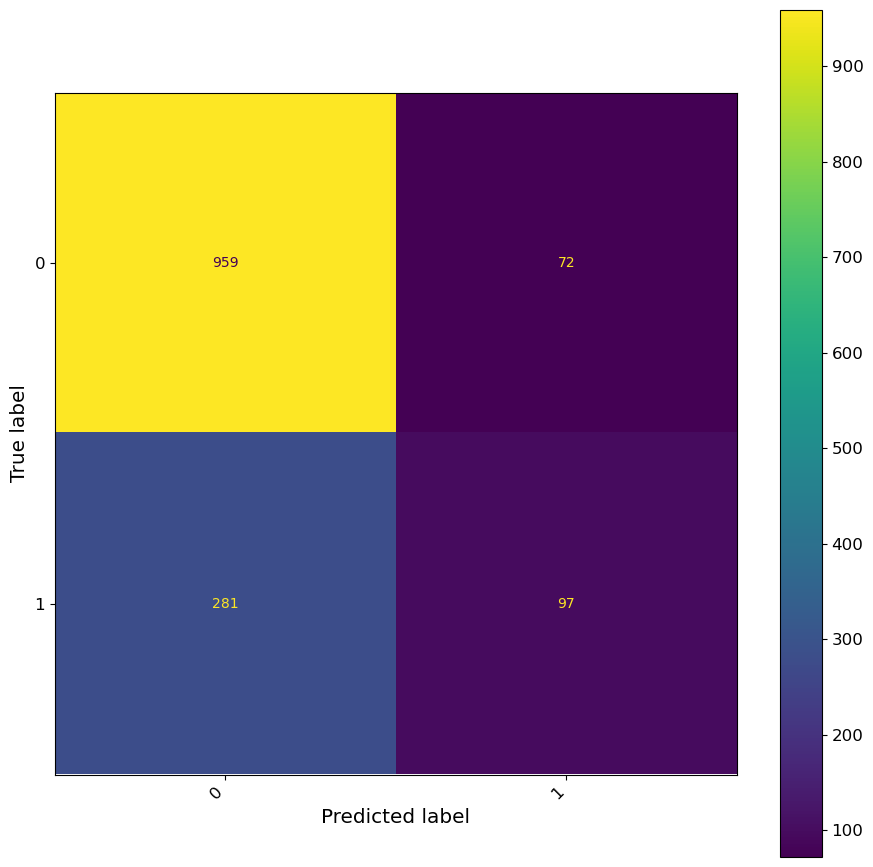

In [82]:
predictions = (nn_pred_binary > .5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(df_test['Churn_Num'], predictions))
disp.plot()
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [83]:
print(classification_report(df_test['Churn_Num'], (nn_pred_binary > .5).astype(int), zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1031
           1       0.57      0.26      0.35       378

    accuracy                           0.75      1409
   macro avg       0.67      0.59      0.60      1409
weighted avg       0.72      0.75      0.71      1409

